In [1]:
# Useful packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sage
import seaborn as sns
import tqdm

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

# Generating the dataset
We take the led dataset and add noise to it to introduce randomness and compare between train and test sets.

In [2]:
def make_noised_led_sample(
    n_samples=200, irrelevant=0, flip_proba=0.1, random_state=None
):
    random_state = check_random_state(random_state)

    data = np.array(
        [
            [0, 0, 1, 0, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 2],
            [1, 0, 1, 1, 0, 1, 1, 3],
            [0, 1, 1, 1, 0, 1, 0, 4],
            [1, 1, 0, 1, 0, 1, 1, 5],
            [1, 1, 0, 1, 1, 1, 1, 6],
            [1, 0, 1, 0, 0, 1, 0, 7],
            [1, 1, 1, 1, 1, 1, 1, 8],
            [1, 1, 1, 1, 0, 1, 1, 9],
            [1, 1, 1, 0, 1, 1, 1, 0],
        ]
    )

    data = data[random_state.randint(0, 10, n_samples)]
    X, y = np.array(data[:, :7], dtype=np.intp), data[:, 7]
    X_noised = np.zeros_like(X)
    for sample in range(n_samples):
        X_noised[sample, :] = np.abs(
            random_state.binomial(n=1, p=flip_proba, size=7) - X[sample, :]
        )
    if irrelevant > 0:
        X_noised = np.hstack((X_noised, random_state.rand(n_samples, irrelevant) > 0.5))
    return X_noised, y


# Compute importances for varying n_sample size

In [3]:
# Define the parameters
train_sizes = [50, 100, 150, 200]
test_sizes = [round(n_samples * 0.33) for n_samples in train_sizes]
n_estimators = 100
flip_proba = 0.2

## MDI

In [11]:
MDI = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for idx, n_samples in enumerate(train_sizes):
    X, y = make_noised_led_sample(
        n_samples=n_samples, flip_proba=flip_proba, random_state=0
    )
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=1,
        max_depth=None,
        min_samples_split=2,
        criterion="entropy",
        verbose=0,
        n_jobs=1,
        random_state=idx,
    )
    model.fit(X, y)
    MDI.loc[:, f"{n_samples}"] = model.feature_importances_

## Unbiased MDI

In [5]:
UMDI = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for idx, n_samples in enumerate(train_sizes):
    X, y = make_noised_led_sample(
        n_samples=n_samples, flip_proba=flip_proba, random_state=0
    )
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=1,
        max_depth=None,
        min_samples_split=2,
        criterion="entropy",
        verbose=0,
        oob_score=True,
        bootstrap=True,
        n_jobs=1,
        random_state=idx,
    )
    model.fit(X, y)
    UMDI.loc[:, f"{n_samples}"] = (
        model._compute_unbiased_feature_importance_and_oob_predictions(X, y, None)[0]
    )

## Shapley values on Training data

In [6]:
SAGE_train = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for idx, n_samples in enumerate(train_sizes):
    X, y = make_noised_led_sample(
        n_samples=n_samples, flip_proba=flip_proba, random_state=0
    )
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=1,
        max_depth=None,
        min_samples_split=2,
        criterion="entropy",
        verbose=0,
        n_jobs=1,
        random_state=idx,
    )
    model.fit(X, y)
    imputer = sage.MarginalImputer(model, X)
    estimator = sage.PermutationEstimator(
        imputer, "cross entropy", n_jobs=1, random_state=idx
    )
    sage_values = estimator(X, y).values
    SAGE_train.loc[:, f"{n_samples}"] = sage_values / sage_values.sum()

100%|██████████| 1/1 [01:14<00:00, 74.51s/it]     


## Shapley values on test data

In [7]:
# Compute MDI for varying training size
SAGE_test = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for (idx, n_samples) in enumerate(train_sizes):
    X, y = make_noised_led_sample(n_samples=n_samples, flip_proba=flip_proba, random_state=0)
    X_test, y_test = make_noised_led_sample(n_samples=test_sizes[idx], flip_proba=flip_proba, random_state=idx + 1000)
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=1,
        max_depth=None,
        min_samples_split=2,
        criterion="entropy",
        verbose=0,
        n_jobs=1,
        random_state=idx,
    )
    model.fit(X, y)
    imputer = sage.MarginalImputer(model, X_test)
    estimator = sage.PermutationEstimator(
        imputer, "cross entropy", n_jobs=1, random_state=idx
    )
    sage_values = estimator(X_test, y_test).values
    SAGE_test.loc[:, f"{n_samples}"] = sage_values / sage_values.sum()

100%|██████████| 1/1 [04:06<00:00, 246.50s/it]     


# Plot the results

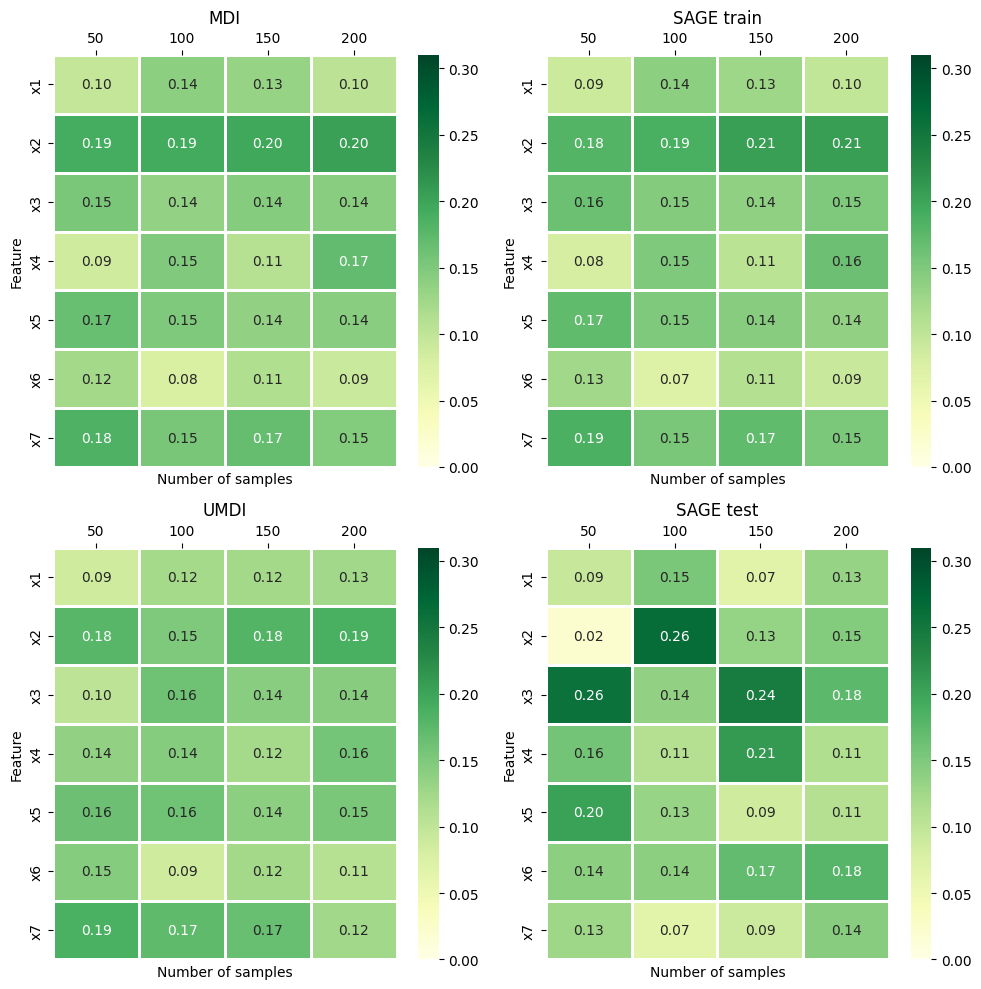

In [12]:
# Plot the heatmaps
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(
    MDI,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[0, 0],
    vmin=0,
    vmax=0.31,
)
axes[0, 0].xaxis.tick_top()
axes[0, 0].set_xlabel("Number of samples")
axes[0, 0].set_ylabel("Feature")
axes[0, 0].set_title("MDI")

sns.heatmap(
    SAGE_train,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[0, 1],
    vmin=0,
    vmax=0.31,
)
axes[0, 1].xaxis.tick_top()
axes[0, 1].set_xlabel("Number of samples")
axes[0, 1].set_ylabel("Feature")
axes[0, 1].set_title("SAGE train")


sns.heatmap(
    UMDI,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[1, 0],
    vmin=0,
    vmax=0.31,
)
axes[1, 0].xaxis.tick_top()
axes[1, 0].set_xlabel("Number of samples")
axes[1, 0].set_ylabel("Feature")
axes[1, 0].set_title("UMDI")


sns.heatmap(
    SAGE_test,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[1, 1],
    vmin=0,
    vmax=0.31,
)
axes[1, 1].xaxis.tick_top()
axes[1, 1].set_xlabel("Number of samples")
axes[1, 1].set_ylabel("Feature")
axes[1, 1].set_title("SAGE test")

plt.tight_layout()
plt.show()

# Compare asymptotics of MDI and UMDI

In [60]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
train_sizes_large = np.logspace(start=2, stop=5, base=10, dtype=np.intp)
n_rep = 10
mdi_all = np.zeros((len(feature_names), len(train_sizes_large), n_rep))
umdi_all = np.zeros((len(feature_names), len(train_sizes_large), n_rep))

train_sizes_large = np.logspace(start=2, stop=5, base=10, dtype=np.intp)
n_rep = 10
for t_idx, n_samples in enumerate(train_sizes_large):
    for rep in range(n_rep):
        X, y = make_noised_led_sample(
            n_samples=n_samples, flip_proba=flip_proba, random_state=rep
        )
        model = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            min_samples_split=2,
            criterion="entropy",
            verbose=0,
            n_jobs=1,
            random_state=rep,
        )
        model.fit(X, y)        
        mdi_all[:, t_idx, rep] = model.feature_importances_

        model = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            min_samples_split=2,
            criterion="entropy",
            verbose=0,
            oob_score=True,
            bootstrap=True,
            n_jobs=1,
            random_state=rep,
        )
        model.fit(X, y)
        umdi_all[:, t_idx, rep] = model._compute_unbiased_feature_importance_and_oob_predictions(X, y, None)[0]

# Plot the evolution of the norm of the difference

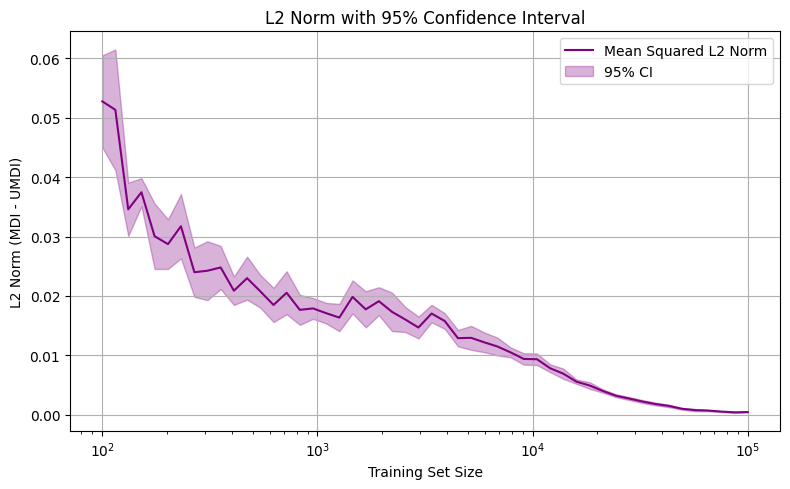

In [66]:
l2_mean = []
l2_sem = []

for t_idx in range(len(train_sizes_large)):
    mdi_vals = mdi_all[:, t_idx, :]
    umdi_vals = umdi_all[:, t_idx, :]

    l2_squared = np.sqrt(np.sum((mdi_vals - umdi_vals) ** 2, axis=0))
    l2_mean.append(l2_squared.mean())
    l2_sem.append(l2_squared.std(ddof=1) / np.sqrt(n_rep))

l2_mean = np.array(l2_mean)
l2_sem = np.array(l2_sem)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes_large, l2_mean, label='Mean Squared L2 Norm', color='purple')
plt.fill_between(
    train_sizes_large,
    l2_mean - 1.96 * l2_sem,
    l2_mean + 1.96 * l2_sem,
    color='purple',
    alpha=0.3,
    label='95% CI'
)

plt.xscale('log')
plt.xlabel('Training Set Size')
plt.ylabel('L2 Norm (MDI - UMDI)')
plt.title('L2 Norm with 95% Confidence Interval')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Compute shapley value decomposition for reference

In [ ]:
MDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
UMDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
n_samples = 1000
X, y = make_noised_led_sample(
    n_samples=n_samples, flip_proba=flip_proba, random_state=0
)
model = ExtraTreesClassifier(
    n_estimators=n_estimators,
    max_features=1,
    max_depth=None,
    min_samples_split=2,
    criterion="entropy",
    verbose=0,
    n_jobs=1,
    random_state=0,
)
model.fit(X, y)
imputer = sage.MarginalImputer(model, X)
estimator = sage.PermutationEstimator(
    imputer, "cross entropy", n_jobs=-1, random_state=0
)
sage_value = estimator(X, y).values
sage_value /= sage_value.sum()

PermutationEstimator will use 14 jobs


  0%|          | 0/1 [00:00<?, ?it/s]

In [75]:
MDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
UMDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)

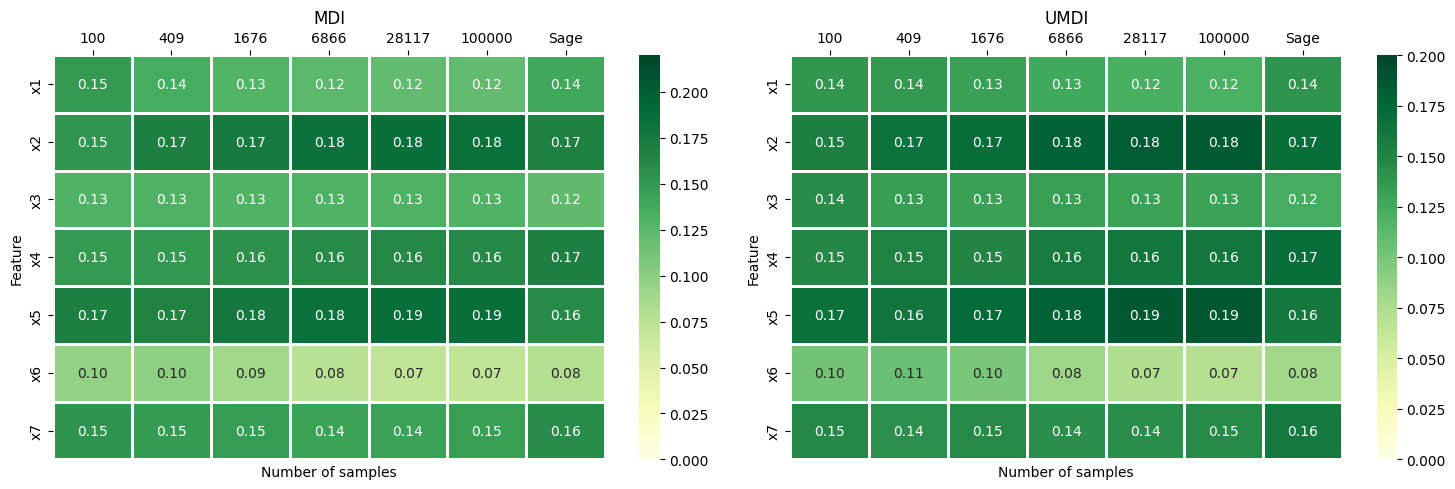

In [77]:
for t_idx in range(len(train_sizes_large)):
    MDI_asymptotic.loc[:,f"{train_sizes_large[t_idx]}"] = np.mean(mdi_all[:, t_idx, :], axis=1)
    UMDI_asymptotic.loc[:,f"{train_sizes_large[t_idx]}"] = np.mean(umdi_all[:, t_idx, :], axis=1)

UMDI_asymptotic.loc[:, "Sage"] = sage_value
MDI_asymptotic.loc[:, "Sage"] = sage_value

# Select a few columns to display on the heatmap
all_cols = list(MDI_asymptotic.columns[:-1])

# Select every 10th column
selected_cols = all_cols[::10]
selected_cols.append(all_cols[-1])
selected_cols.append(MDI_asymptotic.columns[-1])

# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(
    MDI_asymptotic[selected_cols],
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[0],
    vmin=0,
    vmax=0.22,
)
axes[0].xaxis.tick_top()
axes[0].set_xlabel("Number of samples")
axes[0].set_ylabel("Feature")
axes[0].set_title("MDI")

sns.heatmap(
    UMDI_asymptotic[selected_cols],
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[1],
    vmin=0,
    vmax=0.2,
)
axes[1].xaxis.tick_top()
axes[1].set_xlabel("Number of samples")
axes[1].set_ylabel("Feature")
axes[1].set_title("UMDI")

plt.tight_layout()
plt.show()